<a href="https://colab.research.google.com/github/tss1375716572/CT3D/blob/main/CCBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
!pip install mat73
import mat73
import time
from scipy.signal import convolve
import matplotlib.pyplot as plt
import scipy.io as sio

In [ ]:
class CCBR(object):
    """
        FDK method of Circular Cone-Beam Reconstruction
    """
    def __init__(self):
        
        stime = time.time()
        
        dir = "/content/drive/My Drive/Colab Notebooks/Image Reconstruction/"
        self.fname = dir + "data/Circular CBCT_flat_panel_detector.prj"
        self.R = 40     # the distance between source and origin
        self.l = 20     # the total length of virtual detectors or Shepplogan
        self.n = 256    # the number of detector or pixel per row
        self.T = self.l / self.n    # the length of each detector or each pixel
        # the half length of virtual detectors or Shepplogan
        self.hl = (self.l - self.T) / 2
        self.kn = np.linspace(-255, 255, 511)   # the sample of convolve kernel
        raw_data = np.fromfile(self.fname, np.float32)
        # reshape the data as (beta, b, a)
        self.data = raw_data.reshape(360, 256, 256)
        self.pw_data = self.pre_weight()    # pre-weight the data
        # define the convolve kernel
        self.conv_kn = self.rl_filter()[np.newaxis, np.newaxis, :]
        self.conv_data = convolve(self.pw_data, self.conv_kn, mode='same')
 
        # define x, y, z, beta array
        self.x = np.linspace(-self.hl, self.hl, self.n)[np.newaxis, \
                                                        np.newaxis, :]
        self.y = np.linspace(-self.hl, self.hl, self.n)[:, np.newaxis, \
                                                        np.newaxis]
        self.z = np.linspace(self.hl, -self.hl, self.n)[np.newaxis, :, \
                                                        np.newaxis]
        beta_array = np.arange(0, 2 * np.pi, np.pi / 180)
        # initial f_FDK(y, z, x)
        self.f_fdk = np.zeros((self.n, self.n, self.n))
        # integrate f_fdk by beta
        for self.beta in beta_array:
            U, a, b, beta = self.get_Uabbeta_index()
            f = self.R ** 2 / U ** 2 * self.conv_data[beta, b, a]
            self.f_fdk += f
            print("\r Progress: " + str(np.around((self.beta+np.pi/180) / \
                                                  np.pi*50, 1)) + "%", end='')
        # transpose to f(z, y, x) corresponding to Shepplogan
        self.f_fdk = (1 / 2) * self.f_fdk.transpose((1, 0, 2))
        # save as .mat file
        mdic = {"ccbr_fdk_shepplogan": self.f_fdk}
        sio.savemat(dir + "data/ccbr_fdk_shepplogan.mat", mdic)
 
        etime = time.time()
        print("\n Time: " + str(np.around(etime - stime, 1)) + "s!")
 
    def pre_weight(self):
        # define a, b array
        a_array = np.linspace(-self.hl, self.hl, self.n)[np.newaxis, \
                                                         np.newaxis, :]
        b_array = np.linspace(-self.hl, self.hl, self.n)[np.newaxis, :, \
                                                         np.newaxis]
        pre_weighting_factor = self.R / np.sqrt(self.R ** 2 + a_array ** 2 + \
                                                b_array ** 2)
        pre_weighted_data = pre_weighting_factor * self.data
        return pre_weighted_data
    
    def rl_filter(self):
        # define R-L filter
        f = np.zeros(np.shape(self.kn))
        j = 0
        for i in self.kn:
            i = int(i)
            if i == 0:
                f[j] = 1/(2*self.T)**2
            elif i%2:
                f[j] = -1/(i*np.pi*self.T)**2
            else:
                f[j] = 0
            j += 1
        return f
    
    def get_Uabbeta_index(self):
        """Round to nearest"""
        # calculate U
        U = self.R + self.x * np.cos(self.beta) + self.y * np.sin(self.beta)
        # calculate a, b
        a = self.R / U * (-self.x * np.sin(self.beta) + self.y * \
                          np.cos(self.beta))
        b = self.R * self.z / U
        a[a > self.hl] = self.hl
        a[a < -self.hl] = -self.hl
        b[b > self.hl] = self.hl
        b[b < -self.hl] = -self.hl
        a_around = (np.around((a - self.T / 2) / self.T) * self.T + self.T / 2)
        b_around = (np.around((b - self.T / 2) / self.T) * self.T + self.T / 2)
        a_index = ((self.hl + a_around) / self.T).astype(int)
        b_index = ((self.hl + b_around) / self.T).astype(int)
        beta_index = int(np.around(self.beta*180/np.pi))
        return U, a_index, b_index, beta_index

In [ ]:
class HCBR(object):
    """
        FDK method of Helical Cone-Beam Reconstruction
    """
    def __init__(self):
        
        stime = time.time()
        
        dir = "/content/drive/My Drive/Colab Notebooks/Image Reconstruction/"
        self.fname = dir + "data/128sliceHCT_flat_panel_detector.prj"
        self.R = 40     # the distance between source and origin
        self.l = 20     # the total width of virtual detectors or Shepplogan
        self.k = 6.4    # the total hight of virtual detectors
        self.h = 3      # pitch
        self.z0 = -12   # the first z position
        self.n = 256    # the number of detector or pixel per row
        self.m = 128    # the number of detector per column
        self.T = self.l / self.n    # the width of each detector or each pixel
        self.S = self.k / self.m    # the hight of each detector
        # the half length of virtual detectors or Shepplogan
        self.hl = (self.l - self.T) / 2
        self.hh = (self.k - self.S) / 2
        self.kn = np.linspace(-255, 255, 511)   # the sample of convolve kernel
        raw_data = np.fromfile(self.fname, np.float32)
        # reshape the data as (beta, b, a)
        self.data = raw_data.reshape(2880, 128, 256)
        # self.pw_data = self.pre_weight()    # pre-weight the data
        # define the convolve kernel
        self.conv_kn = self.rl_filter()[np.newaxis, np.newaxis, :]
        # self.conv_data = convolve(self.pw_data, self.conv_kn, mode='same')
 
        # define x, y, z, beta array
        self.x = np.linspace(-self.hl, self.hl, self.n)[np.newaxis, \
                                                        np.newaxis, :]
        self.y = np.linspace(-self.hl, self.hl, self.n)[:, np.newaxis, \
                                                        np.newaxis]
        self.z = np.linspace(self.hl, -self.hl, self.n)[np.newaxis, :, \
                                                        np.newaxis]
        beta_array = np.arange(0, 16 * np.pi, np.pi / 180)
        self.z_beta = (self.z0 + self.h * beta_array / (2 * np.pi))[:, np.newaxis, np.newaxis]
        self.pw_data = self.pre_weight()
        self.conv_data = convolve(self.pw_data, self.conv_kn, mode='same')
        b_spilth = np.zeros((2880, 256))[:, np.newaxis, :]
        a_spilth = np.zeros((2880, 129))[:, :, np.newaxis]
        self.f_data = \
        np.concatenate((np.concatenate((self.conv_data, b_spilth), axis=1), \
                        a_spilth), axis=2)
        # initial f_FDK(y, z, x)
        self.f_fdk = np.zeros((self.n, self.n, self.n))
        # integrate f_fdk by beta
        for self.beta in beta_array:
            # self.z_beta = self.z0 + self.h * self.beta / (2 * np.pi)
            # self.pw_data = self.pre_weight()
            U, a, b, beta = self.get_Uabbeta_index()
            f = self.R ** 2 / U ** 2 * self.f_data[beta, b, a]
            self.f_fdk += f
            print("\r Progress: " + str(np.around((self.beta+np.pi/180) / \
                                                  np.pi*25/4, 2)) + "%", end='')
        # transpose to f(z, y, x) corresponding to Shepplogan
        self.f_fdk = (1 / 2) * self.f_fdk.transpose((1, 0, 2))
        # save as .mat file
        mdic = {"hcbr_fdk_shepplogan": self.f_fdk}
        sio.savemat(dir + "data/hcbr_fdk_shepplogan.mat", mdic)
 
        etime = time.time()
        print("\n Time: " + str(np.around(etime - stime, 1)) + "s!")
 
    def pre_weight(self):
        # define a, b array
        a_array = np.linspace(-self.hl, self.hl, self.n)[np.newaxis, \
                                                         np.newaxis, :]
        b_array = np.linspace(-self.hh, self.hh, self.m)[np.newaxis, :, \
                                                         np.newaxis]
        b_array = b_array + self.z_beta
        pre_weighting_factor = self.R / np.sqrt(self.R ** 2 + a_array ** 2 + \
                                                b_array ** 2)
        pre_weighted_data = pre_weighting_factor * self.data
        return pre_weighted_data
    
    def rl_filter(self):
        # define R-L filter
        f = np.zeros(np.shape(self.kn))
        j = 0
        for i in self.kn:
            i = int(i)
            if i == 0:
                f[j] = 1/(2*self.T)**2
            elif i%2:
                f[j] = -1/(i*np.pi*self.T)**2
            else:
                f[j] = 0
            j += 1
        return f
    
    def get_Uabbeta_index(self):
        """Round to nearest"""
        # calculate U
        U = self.R + self.x * np.cos(self.beta) + self.y * np.sin(self.beta)
        # calculata a, b
        a = self.R / U * (-self.x * np.sin(self.beta) + self.y * \
                          np.cos(self.beta))
        b = self.R * (self.z - self.h * self.beta / (2 * np.pi)) / U
        # a[a > self.hl] = self.n
        # a[a < -self.hl] = self.n
        # b[b > self.hh] = self.m
        # b[b < -self.hh] = self.m
        a_around = (np.around((a - self.T / 2) / self.T) * self.T + self.T / 2)
        b_around = (np.around((b - self.S / 2) / self.S) * self.S + self.S / 2)
        a_index = ((self.hl + a_around) / self.T).astype(int)
        b_index = ((self.hh + b_around) / self.S).astype(int)
        a_index[a_index >= self.n] = self.n
        a_index[a_index < 0] = self.n
        b_index[b_index >= self.m] = self.m
        b_index[b_index < 0] = self.m
        beta_index = int(np.around(self.beta*180/np.pi))
        return U, a_index, b_index, beta_index

In [ ]:
class Analysis(object):
    def __init__(self):
        dir = "/content/drive/My Drive/Colab Notebooks/Image Reconstruction/"
        original = mat73.loadmat(dir + 'data/Shepplogan.mat')['Shepplogan']
        fdk_data = sio.loadmat(dir + 'data/hcbr_fdk_shepplogan.mat')\
        ['hcbr_fdk_shepplogan']
        plt.figure("ori")
        # plt.imshow(original[127, :, :], vmin=0.98, vmax=1.05, cmap='gray')
        plt.imshow(original[127, :, :] / np.max(original), vmin=0.49, vmax=0.52, cmap='gray')
        plt.colorbar()
 
        plt.figure('ccbr')
        # plt.imshow(fdk_data[127, :, :] / np.max(fdk_data), vmin=0.43, vmax=0.495, cmap='gray')      # , vmin=72.05, vmax=76.7
        plt.imshow(fdk_data[127, :, :], cmap='gray')
        plt.colorbar()
        plt.show()

In [ ]:
c = CCBR()

 Progress: 100.0%
 Time: 154.6s!


In [ ]:
h = HCBR()

 Progress: 100.0%
 Time: 1358.0s!


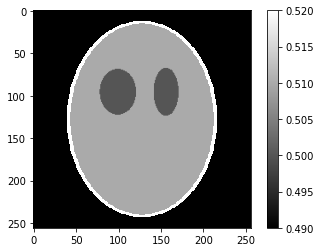

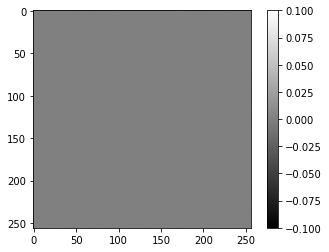

In [ ]:
a = Analysis ()

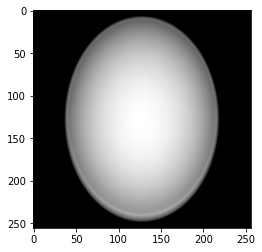

In [ ]:
raw_data = np.fromfile("/content/drive/My Drive/Colab Notebooks/Image Reconstruction/data/128sliceHCT_flat_panel_detector.prj", np.float32)
raw_data = np.fromfile("/content/drive/My Drive/Colab Notebooks/Image Reconstruction/data/Circular CBCT_flat_panel_detector.prj", np.float32)
# data = mat73.loadmat('/content/drive/My Drive/Colab Notebooks/Image Reconstruction/data/Shepplogan.mat')['Shepplogan'][:, 95, :]    # 头模型xyz
data = raw_data.reshape(360, 256, 256)[89, :, :]
# data = raw_data.reshape(256, 128, 2880, order='F')[:, :, 0]
plt.imshow(data, cmap='gray')
plt.show()